In [40]:
import re

# Load the file
with open('long_conversation_analysis_trump_01_12_2017_text.txt', 'r', encoding='utf-8') as f:
    data = f.read()

# Normalize line endings and strip leading numbers before "Tweet ID:"
data = re.sub(r'\n\d+\s*\nTweet ID:', r'\nTweet ID:', data)

# Split into tweet blocks using 'Tweet ID:' as a reliable delimiter
blocks = re.split(r'Tweet ID:\s*', data)[1:]  # Skip first empty split

tweets = {}

for block in blocks:
    try:
        # Capture the tweet ID and extract metadata with regex
        match = re.search(
            r'^(\d+)\s+From User\s+(.*?)\s+In reply to tweet ID:\s+(.*?)\s+In reply to User:\s+.*?\n(.+)',
            block.strip(),
            re.DOTALL
        )

        if not match:
            print(f"Skipped malformed block:\n{block[:200]}\n")
            continue

        tweet_id = match.group(1).strip()
        from_user = match.group(2).strip()
        in_reply_to_id_raw = match.group(3).strip()
        in_reply_to_id = None if in_reply_to_id_raw == 'None' else in_reply_to_id_raw
        content = match.group(4).strip()

        tweets[tweet_id] = {
            'from_user': from_user,
            'in_reply_to_id': in_reply_to_id,
            'content': content
        }

    except Exception as e:
        print(f"Error parsing block:\n{block[:200]}\nError: {e}\n")





In [53]:
# Check if the first tweet is present
first_tweet_id = '935173088869847040'
first_tweet_info = tweets.get(first_tweet_id, None)

first_tweet_info

{'from_user': 'Mcasey80',
 'in_reply_to_id': None,
 'content': 'This is my new account since I got banned by twitter. My previous Handle was @ mcasey84. UK KEK.'}

In [41]:
# Build graph
G = nx.DiGraph()

# First, add nodes for all tweets
for tweet_id, info in tweets.items():
    G.add_node(tweet_id, user=info['from_user'], content=info['content'])

# Then, add edges for replies
for tweet_id, info in tweets.items():
    if info['in_reply_to_id'] and info['in_reply_to_id'] in tweets:
        # Directed edge from reply -> original tweet
        G.add_edge(info['in_reply_to_id'], tweet_id)

# Example: Print basic info
print(f"Total tweets: {len(G.nodes)}")
print(f"Total replies (edges): {len(G.edges)}")


Total tweets: 35238
Total replies (edges): 34815


In [42]:
import pandas as pd
import networkx as nx


# Step 1: Helper function to trace a tweet's root
def find_root(graph, node):
    while True:
        predecessors = list(graph.predecessors(node))
        if not predecessors:
            return node
        node = predecessors[0]

# Step 2: Collect all unique root tweets
all_roots = set()

for tweet_id in G.nodes:
    root = find_root(G, tweet_id)
    all_roots.add(root)

# Step 3: Longest path DFS from each true root
def longest_path_dfs(graph, node, path=None):
    if path is None:
        path = [node]
    neighbors = list(graph.successors(node))
    if not neighbors:
        return path
    longest = path
    for neighbor in neighbors:
        current_path = longest_path_dfs(graph, neighbor, path + [neighbor])
        if len(current_path) > len(longest):
            longest = current_path
    return longest

# Step 4: Store results
all_longest_conversations = []
conversation_id = 1

for start in all_roots:
    longest_path = longest_path_dfs(G, start)
    if len(longest_path) > 1:
        for i, tweet_id in enumerate(longest_path, start=1):
            info = tweets[tweet_id]
            all_longest_conversations.append({
                'Tweet ID': tweet_id,
                'Tweet contents': info['content'],
                'User': info['from_user'],
                'Conversation ID': conversation_id,
                'Number in convo': i
            })
        conversation_id += 1

# Step 5: Create the final DataFrame
df_conversations = pd.DataFrame(all_longest_conversations)

# Optional: Preview
df_conversations.head()


,Tweet ID,Tweet contents,User,Conversation ID,Number in convo
0,934948011440033794,This is sad. I have many friends and family wi...,DLoesch,1,1
1,934994526149554176,@DLoesch When libs are pushing to overthrow a ...,RobertL78,1,2
2,935683215217647616,@RobertL78 @DLoesch Legality is question of hi...,caldwellrobby3,1,3
3,935919527807746048,@caldwellrobby3 @DLoesch Or maybe the exit pol...,RobertL78,1,4
4,935919867672215552,"@caldwellrobby3 @DLoesch You must mean by ""pur...",RobertL78,1,5


In [24]:
df_conversations

,Tweet ID,Tweet contents,User,Conversation ID,Number in convo
0,914734871213432833,@realDonaldTrump @DonaldJTrumpJr @EricTrump h...,ReallySunnyDay,1,1
1,914735105293344768,@realDonaldTrump @DonaldJTrumpJr @EricTrump h...,ReallySunnyDay,1,2
2,914840150668169217,"@realDonaldTrump @DonaldJTrumpJr @EricTrump ""T...",ReallySunnyDay,1,3
3,935959836205953025,Zero tolerance means consequences – for everyo...,NancyPelosi,2,1
4,935963714292932608,"@NancyPelosi Then, in that regard, you should ...",Uberficker,2,2
...,...,...,...,...,...
15720,933340763492143104,@SenateDems @HouseDemocrats @NBCNews @MSNBC @m...,THE5STARLIBERAL,1643,3
15721,933342443612893184,@SenateDems @HouseDemocrats @NBCNews @MSNBC @m...,THE5STARLIBERAL,1643,4
15722,933342943620009987,@SenateDems @HouseDemocrats @NBCNews @MSNBC @m...,THE5STARLIBERAL,1643,5
15723,933344079886323713,@SenateDems @HouseDemocrats @NBCNews @MSNBC @m...,THE5STARLIBERAL,1643,6


In [52]:
for convo_id in df_conversations['Conversation ID'].unique()[:3]:
    print(f"\nConversation {convo_id}:")
    sub = df_conversations[df_conversations['Conversation ID'] == convo_id]
    for _, row in sub.iterrows():
        print(f"  {row['Number in convo']}: @{row['User']} → {row['Tweet contents'][:200]}")


Conversation 1:
  1: @DLoesch → This is sad. I have many friends and family with whom I disagree politically. Refusing to engage outside of your bubble is neither healthy nor unifying. https://t.co/TtJbghRLKx
  2: @RobertL78 → @DLoesch When libs are pushing to overthrow a legally elected president, undermine our Republic and it's heritage, cram ideological perversities down our throats, and all with an air of self-righteous
  3: @caldwellrobby3 → @RobertL78 @DLoesch Legality is question of his legitimacy as president . We already know gop with kris kobach purg… https://t.co/sXzXZE0Fwr
  4: @RobertL78 → @caldwellrobby3 @DLoesch Or maybe the exit polls were manipulated like many of the polls which predicted an overwhelming victory for HRC.
  5: @RobertL78 → @caldwellrobby3 @DLoesch You must mean by "purged" that those ineligible to vote were purged. We now know that vote… https://t.co/HqBT2qETaO
  6: @caldwellrobby3 → @RobertL78 @DLoesch When I say purged , I mean . Kris kobach and 32 o

In [45]:
original_tweet_ids = [tid for tid, info in tweets.items() if info['in_reply_to_id'] is None]
starting_tweet_ids = df_conversations[df_conversations['Number in convo'] == 1]['Tweet ID'].tolist()
missing_roots = [tid for tid in original_tweet_ids if tid not in starting_tweet_ids]
print(f"Original root tweets not included in df_conversations: {len(missing_roots)}")

# Optional: Show a few examples
for tid in missing_roots[:5]:
    print(f"Missing root tweet: {tid} — {tweets[tid]['from_user']} — {tweets[tid]['content'][:80]}")


Original root tweets not included in df_conversations: 0


In [48]:
print(f"Total parsed tweets: {len(tweets)}")


Total parsed tweets: 35238


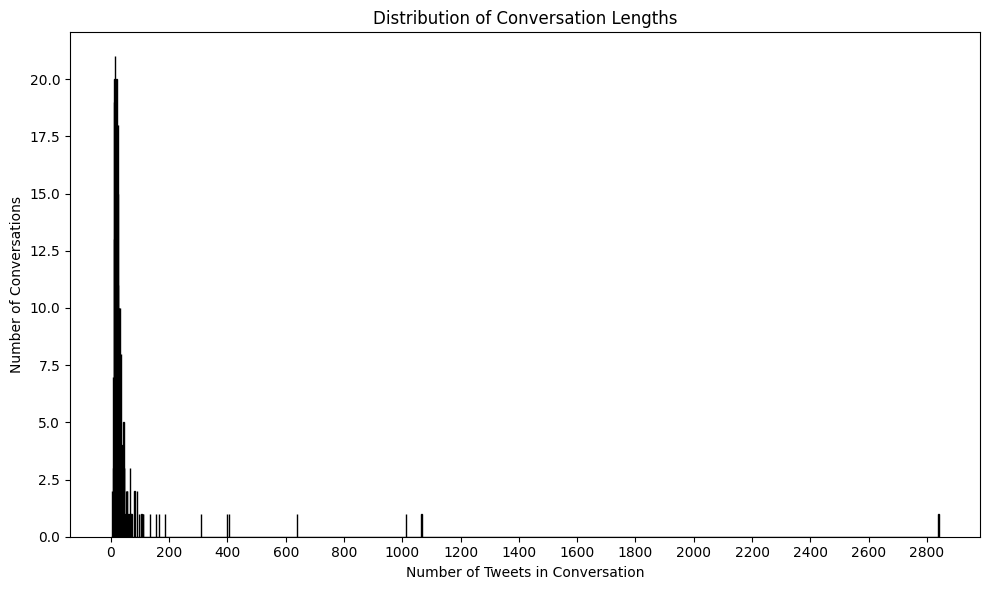

In [57]:
import matplotlib.pyplot as plt

# Step 1: Calculate conversation lengths
conversation_lengths = df_conversations.groupby("Conversation ID")["Tweet ID"].count()

# Step 2: Plot with fewer x-axis ticks
plt.figure(figsize=(10, 6))
plt.hist(conversation_lengths, bins=range(2, conversation_lengths.max() + 2), edgecolor='black')

plt.title("Distribution of Conversation Lengths")
plt.xlabel("Number of Tweets in Conversation")
plt.ylabel("Number of Conversations")

# Only show every nth x-tick
tick_spacing = 200  # Change to 5 if you want even fewer ticks
x_ticks = list(range(0, conversation_lengths.max() + 1, tick_spacing))
plt.xticks(x_ticks)

plt.tight_layout()
plt.show()


In [ ]:
df_conversations.to_csv("